In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import h3
import torch
from torch_geometric.loader import DataLoader

In [2]:
with open("zone_times/inference_times.json", "r") as f:
    inference_time = json.load(f)

In [3]:
with open("zone_times/inference_times_10.json", "r") as f:
    inference_time_10 = json.load(f)

In [3]:
with open("zone_results/times_pred.json", "r") as f:
    times_pred = json.load(f)

In [4]:
with open("zone_results/times_actual.json", "r") as f:
    times_actual = json.load(f)

In [5]:
with open("zone_results/times_dif.json", "r") as f:
    times_dif = json.load(f)

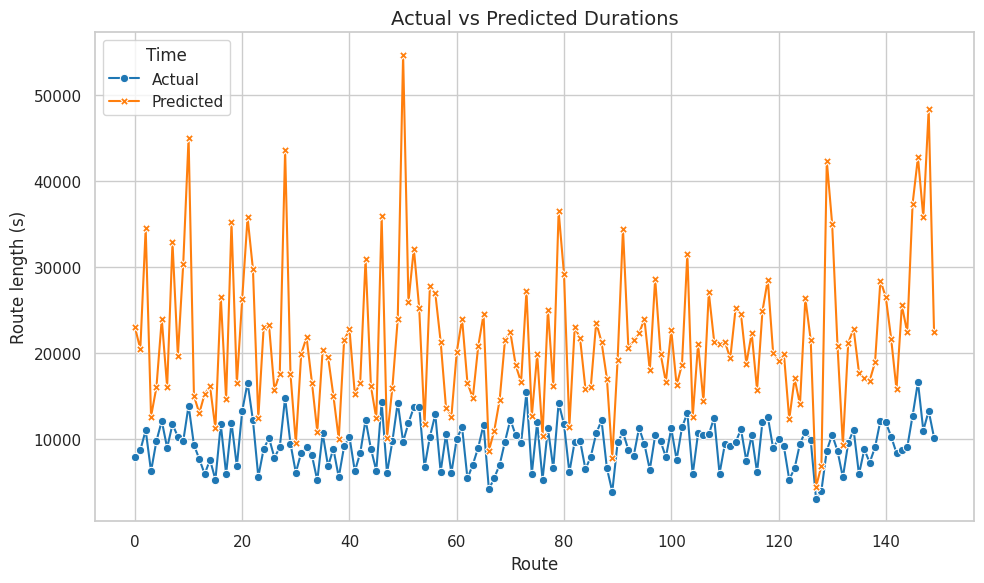

In [6]:
sns.set_theme(style="whitegrid")

df_results = pd.DataFrame({
    'Index': list(range(150)) * 2,
    'Duration (s)': times_actual[:150] + times_pred[:150],
    'Time': ['Actual'] * 150 + ['Predicted'] * 150
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='Index', y='Duration (s)', hue='Time', style='Time',
             markers=True, dashes=False, palette=['#1f77b4', '#ff7f0e'])

plt.title('Actual vs Predicted Durations', fontsize=14)
plt.xlabel('Route')
plt.ylabel('Route length (s)')
plt.tight_layout()
plt.grid(True)
plt.show()

In [8]:
times_dif_arr = np.array(times_dif)
print(f"Avg error: {times_dif_arr.mean().item()}")
print(f"Median: {np.quantile(times_dif_arr, 0.5)}")
print(f"Quantile 0.25: {np.quantile(times_dif_arr, 0.25)}")
print(f"Quantile 0.75: {np.quantile(times_dif_arr, 0.75)}")
print(f"Quantile 0.9: {np.quantile(times_dif_arr, 0.9)}")
# print(f"Quantile 0.95: {np.quantile(times_dif_arr, 0.95)}")
# print(f"Quantile 0.99: {np.quantile(times_dif_arr, 0.99)}")
print(f"Max error: {times_dif_arr.max()}")
print(f"Min error: {times_dif_arr.min()}")
print(f"Route with max error: {np.argmax(times_dif_arr)}")
print(f"Route with min error: {np.argmin(times_dif_arr)}")

Avg error: 12620.928659286594
Median: 11580.349999999988
Quantile 0.25: 8118.849999999997
Quantile 0.75: 15494.874999999995
Quantile 0.9: 20692.650000000005
Max error: 53103.29999999998
Min error: 1278.400000000001
Route with max error: 1103
Route with min error: 1302


In [9]:
print(f"Avg actual route length: {np.mean(times_actual)}")
print(f"Avg predicted route length: {np.mean(times_pred)}")

Avg actual route length: 9352.673985239851
Avg predicted route length: 21973.60264452645


In [10]:
dif_percent = []

for pred, actual in zip(times_pred, times_actual):
    dif_percent.append((abs(actual - pred) / abs(actual)) * 100)

dif_percent_arr = np.array(dif_percent)
dif_percent_arr.mean().item()

134.56680569566512

In [4]:
df = pd.read_parquet("../df_la_test.parquet")

In [5]:
with open("zone_dfs/labels_dict.json") as f:
    labels_dict = json.load(f)

In [6]:
df.loc[:, "h3_index"] = df.apply(lambda row: h3.latlng_to_cell(row["lat"], row["lng"], res=6), axis=1)
df.loc[:, "cluster"] = df.apply(lambda row: labels_dict.get(row["h3_index"], -1.0), axis=1)

In [7]:
route_ids = []

graph_list = torch.load("graph_lists/graph_list_test_zone_def.pt", weights_only=False)
loader = DataLoader(graph_list, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)

for graph in loader: route_ids.append(graph.route_id[0])

In [8]:
num_clusters = []

for route in route_ids:
    n_clusters = df[df["route_id"] == route]["cluster"].nunique()
    num_clusters.append(n_clusters)

In [24]:
one_cluster = []
two_clusters = []
three_clusters = []
four_clusters = []
five_clusters = []

for n, t in zip(num_clusters, inference_time):
    if n == 1:
        one_cluster.append(t)
    elif n == 2:
        two_clusters.append(t)
    elif n == 3:
        three_clusters.append(t)
    elif n == 4:
        four_clusters.append(t)
    else:
        five_clusters.append(t)

In [25]:
time_one = np.mean(one_cluster)
time_two = np.mean(two_clusters)
time_three = np.mean(three_clusters)
time_four = np.mean(four_clusters)
time_five = np.mean(five_clusters)

print(f"One cluster: {time_one}")
print(f"Two cluster: {time_two}")
print(f"Three cluster: {time_three}")
print(f"Four cluster: {time_four}")
print(f"Five cluster: {time_five}")

One cluster: 0.06758330017328262
Two cluster: 0.052142505716133825
Three cluster: 0.04750111222811486
Four cluster: 0.044420046684069514
Five cluster: 0.034265995025634766


In [9]:
with open("inference_times_general.json", "r") as f:
    general_inference_times = json.load(f)

with open("inference_times_general_10.json", "r") as f:
    general_inference_times_10 = json.load(f)

In [29]:
general_avg = np.mean(general_inference_times)
general_avg

np.float64(0.056085681270116074)

In [10]:
general_inf_avgs = []

for i in range(10):
    general_inf_avgs.append(np.mean(general_inference_times_10[i]).item())

general_inf_avgs

[0.054380797665350845,
 0.05427096529347137,
 0.054309561537054046,
 0.05434882904770629,
 0.05415298138157468,
 0.054173477021530546,
 0.05434667477601862,
 0.05432068568460762,
 0.054334351497382694,
 0.05443404492123687]

In [11]:
general_avg_10 = np.mean(general_inf_avgs)
min_avg = np.min(general_inf_avgs)
max_avg = np.max(general_inf_avgs)

In [46]:
print(general_avg_10)
print(min_avg)
print(max_avg)

0.054307236882593354
0.05415298138157468
0.05443404492123687


In [12]:
one_cluster_10 = []
two_clusters_10 = []
three_clusters_10 = []
four_clusters_10 = []
five_clusters_10 = []

for i in range(10):
    iter_inf_times = inference_time_10[i]
    partial_one = []
    partial_two = []
    partial_three = []
    partial_four = []
    partial_five = []
    for n, t in zip(num_clusters, iter_inf_times):
        if n == 1:
            partial_one.append(t)
        elif n == 2:
            partial_two.append(t)
        elif n == 3:
            partial_three.append(t)
        elif n == 4:
            partial_four.append(t)
        else:
            partial_five.append(t)
    one_cluster_10.append(partial_one)
    two_clusters_10.append(partial_two)
    three_clusters_10.append(partial_three)
    four_clusters_10.append(partial_four)
    five_clusters_10.append(partial_five)

In [13]:
one_avgs = []
two_avgs = []
three_avgs = []
four_avgs = []
five_avgs = []

for i in range(10):
    one_avgs.append(np.mean(one_cluster_10[i]).item())
    two_avgs.append(np.mean(two_clusters_10[i]).item())
    three_avgs.append(np.mean(three_clusters_10[i]).item())
    four_avgs.append(np.mean(four_clusters_10[i]).item())
    five_avgs.append(np.mean(five_clusters_10[i]).item())

In [51]:
print(np.mean(five_avgs))
print(np.max(five_avgs))
print(np.min(five_avgs))

0.0350395679473877
0.037676334381103516
0.033997297286987305


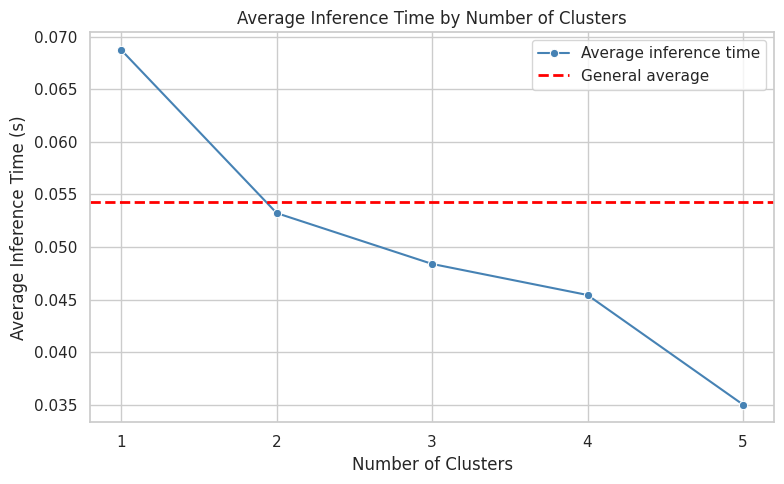

In [18]:
df_avg_times = pd.DataFrame({
    'Clusters': [1, 2, 3, 4, 5],
    'Avg Duration (s)': [np.mean(one_avgs), np.mean(two_avgs), np.mean(three_avgs), np.mean(four_avgs), np.mean(five_avgs)],
})

# Estilo del gráfico
sns.set_theme(style="whitegrid")

# Crear figura
plt.figure(figsize=(8, 5))

# Gráfico de barras
sns.lineplot(data=df_avg_times, x='Clusters', y='Avg Duration (s)', color='steelblue', marker='o', dashes=False, label="Average inference time")

plt.axhline(y=general_avg_10, color='red', linestyle='--', linewidth=2, label='General average')
# plt.axhline(y=min_avg, color='black', linestyle='--', linewidth=2, label='Min avg')
# plt.axhline(y=max_avg, color='black', linestyle='--', linewidth=2, label='Max avg')

# Añadir etiquetas sobre las barras
# for bar in ax.patches:
#     height = bar.get_height()
#     ax.text(
#         bar.get_x() + bar.get_width() / 2,
#         height,
#         f'{height:.1f}',
#         ha='center',
#         va='bottom',
#         fontsize=9
#     )

# Etiquetas y título
plt.title('Average Inference Time by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.xticks(ticks=[1,2,3,4,5])
plt.ylabel('Average Inference Time (s)')
plt.legend()
plt.tight_layout()
plt.show()

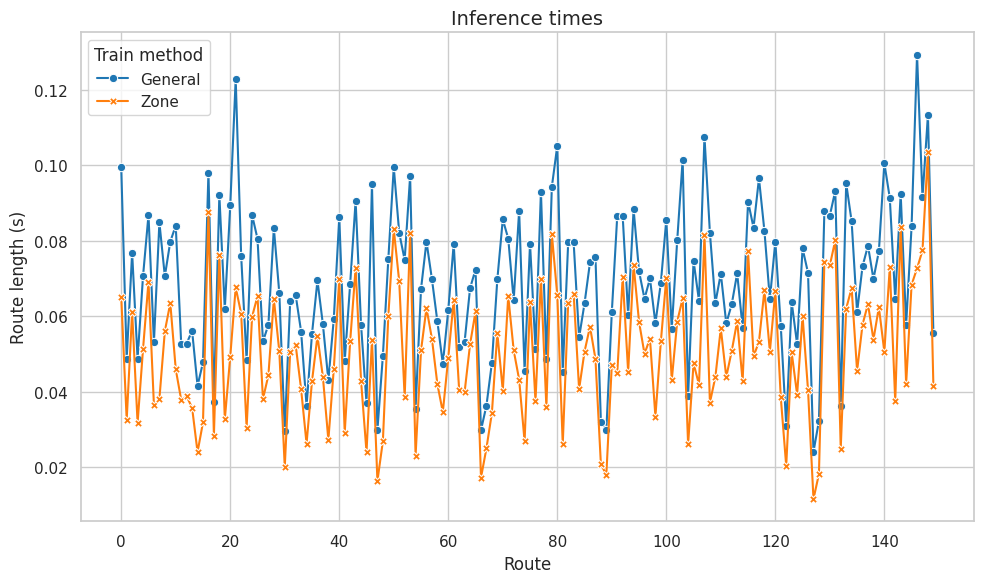

In [ ]:
sns.set_theme(style="whitegrid")

df_results = pd.DataFrame({
    'Index': list(range(150)) * 2,
    'Inference time (s)': general_inference_times[:150] + inference_time[:150],
    'Train method': ['General'] * 150 + ['Zone'] * 150
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='Index', y='Inference time (s)', hue='Train method', style='Train method',
             markers=True, dashes=False, palette=['#1f77b4', '#ff7f0e'])

plt.title('Inference times', fontsize=14)
plt.xlabel('Route')
plt.ylabel('Route length (s)')
plt.tight_layout()
plt.grid(True)
plt.show()

In [22]:
with open("times_pred_general.json", "r") as f:
    times_pred_general = json.load(f)

with open("times_actual_general.json", "r") as f:
    times_actual_general = json.load(f)

In [43]:
results = {
    0 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    1 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    2 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    3 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    4 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    }
}

In [44]:
for i in range(len(num_clusters)):
    n = num_clusters[i]
    if n == 5: n = 4
    d = results[n]
    d["route_ids"].append(route_ids[i])
    d["actual_times"].append(times_actual[i])
    d["pred_general"].append(times_pred_general[i])
    d["pred_zone"].append(times_pred[i])

In [46]:
for i in range(1, 5):
    d = results[i]
    print(f"{i} clusters - Actual avg: {np.mean(d["actual_times"])}")
    print(f"{i} clusters - General pred avg: {np.mean(d["pred_general"])}")

    dif_percent_general = []

    for pred, actual in zip(d["pred_general"], d["actual_times"]):
        dif_percent_general.append((abs(actual - pred) / abs(actual)) * 100)

    print(f"{i} clusters - General pred error percentage: {np.array(dif_percent_general).mean().item()}")


    print(f"{i} clusters - Zone pred avg: {np.mean(d["pred_zone"])}")

    dif_percent_zone = []

    for pred, actual in zip(d["pred_zone"], d["actual_times"]):
        dif_percent_zone.append((abs(actual - pred) / abs(actual)) * 100)

    print(f"{i} clusters - Zone pred error percentage: {np.array(dif_percent_zone).mean().item()}")

    

1 clusters - Actual avg: 9366.5953125
1 clusters - General pred avg: 32939.9921875
1 clusters - General pred error percentage: 250.6698729274578
1 clusters - Zone pred avg: 33320.6015625
1 clusters - Zone pred error percentage: 255.512125160519
2 clusters - Actual avg: 8843.22463099631
2 clusters - General pred avg: 27768.22453874539
2 clusters - General pred error percentage: 204.80115878575108
2 clusters - Zone pred avg: 20858.34474169742
2 clusters - Zone pred error percentage: 134.80972572677462
3 clusters - Actual avg: 10386.347945205478
3 clusters - General pred avg: 35747.641324200915
3 clusters - General pred error percentage: 234.96250670965046
3 clusters - Zone pred avg: 22742.68493150685
3 clusters - Zone pred error percentage: 117.92013936360655
4 clusters - Actual avg: 11817.7475
4 clusters - General pred avg: 42414.407499999994
4 clusters - General pred error percentage: 255.07275226600296
4 clusters - Zone pred avg: 25620.442499999997
4 clusters - Zone pred error percent

In [47]:
results2 = {
    100 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    120 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    140 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    160 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    180 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    200 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    },
    250 : {
        "route_ids" : [],
        "actual_times" : [],
        "pred_general" : [],
        "pred_zone" : []
    }
}

In [56]:
for i in range(len(route_ids)):
    route_id = route_ids[i]
    route_length = df[df["route_id"] == route_id]["stop_id"].nunique()
    if route_length <= 100:
        n = 100
    elif route_length <= 120:
        n = 120
    elif route_length <= 140:
        n = 140
    elif route_length <= 160:
        n = 160 
    elif route_length <= 180:
        n = 180
    elif route_length <= 200:
        n = 200
    else:
        n = 250

    d = results2[n]
    d["route_ids"].append(route_ids[i])
    d["actual_times"].append(times_actual[i])
    d["pred_general"].append(times_pred_general[i])
    d["pred_zone"].append(times_pred[i])

In [60]:
for k in results2.keys():
    d = results2[k]
    print(f"Under {k} stops - Actual avg: {np.mean(d["actual_times"])}")
    print(f"Under {k} stops clusters - General pred avg: {np.mean(d["pred_general"])}")
    print(f"Under {k} stops - Zone pred avg: {np.mean(d["pred_zone"])}")

    dif_percent_general = []

    for pred, actual in zip(d["pred_general"], d["actual_times"]):
        dif_percent_general.append((abs(actual - pred) / abs(actual)) * 100)

    print(f"Under {k} stops - General pred error percentage: {np.array(dif_percent_general).mean().item()}")
    
    dif_percent_zone = []

    for pred, actual in zip(d["pred_zone"], d["actual_times"]):
        dif_percent_zone.append((abs(actual - pred) / abs(actual)) * 100)

    print(f"Under {k} stops - Zone pred error percentage: {np.array(dif_percent_zone).mean().item()}")

Under 100 stops - Actual avg: 5678.269651741294
Under 100 stops clusters - General pred avg: 13307.437313432838
Under 100 stops - Zone pred avg: 11186.860696517411
Under 100 stops - General pred error percentage: 132.6105815978423
Under 100 stops - Zone pred error percentage: 98.16017600817128
Under 120 stops - Actual avg: 7717.516194331984
Under 120 stops clusters - General pred avg: 21032.566801619432
Under 120 stops - Zone pred avg: 16518.208502024292
Under 120 stops - General pred error percentage: 172.46798175804346
Under 120 stops - Zone pred error percentage: 118.48852651966214
Under 140 stops - Actual avg: 9051.586039886039
Under 140 stops clusters - General pred avg: 28936.649857549863
Under 140 stops - Zone pred avg: 20606.55128205128
Under 140 stops - General pred error percentage: 215.2451986319317
Under 140 stops - Zone pred error percentage: 132.34818283083843
Under 160 stops - Actual avg: 10366.369596199524
Under 160 stops clusters - General pred avg: 34544.19809976247
U